Epoch 1/50


d:\Capstone\El Nino\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1449
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0920 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0372 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0279 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0249 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0279
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0267
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0286
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0279 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0214 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0240 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0224 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0184 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0266 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0200 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/s

C:\Users\rumma\AppData\Local\Temp\ipykernel_3268\3733133027.py:107: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df_location.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")


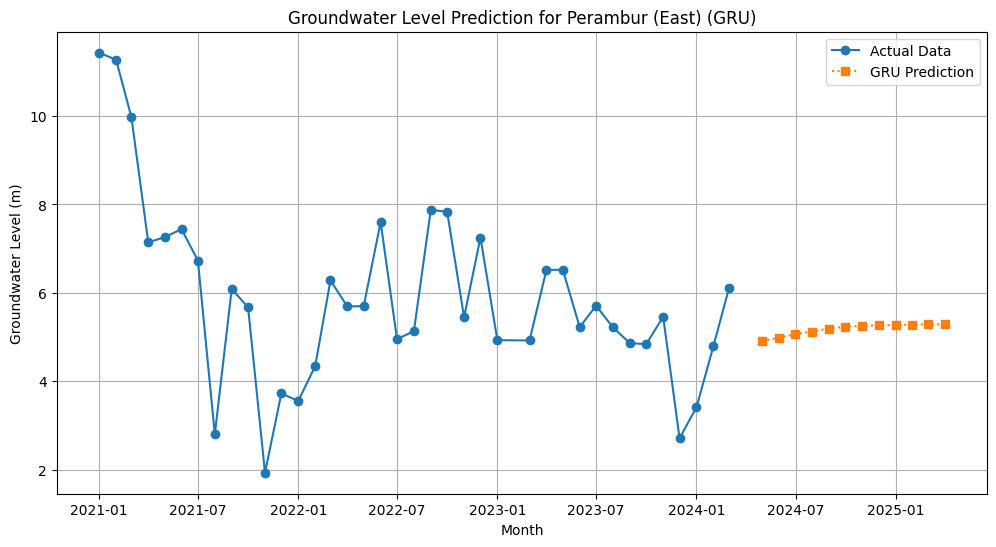

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# File paths for 2021-2024 datasets
file_paths = {
    2021: "../dataset/chennai-ground-water-levels-2021.csv",
    2022: "../dataset/chennai-ground-water-levels-2022.csv",
    2023: "../dataset/chennai-ground-water-levels-2023.csv",
    2024: "../dataset/chennai-ground-water-levels-2024.csv"
}

# Load all datasets into a single DataFrame
df_list = []
for year, path in file_paths.items():
    df = pd.read_csv(path)
    df["Year"] = year  # Add Year column
    df_list.append(df)

df_all_years = pd.concat(df_list)

# Fix month column names by stripping spaces
df_all_years.rename(columns=lambda x: x.strip(), inplace=True)

# Updated month list without spaces
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Convert to numeric
df_all_years[months] = df_all_years[months].apply(pd.to_numeric, errors='coerce')

# Select a specific location for forecasting (e.g., Perambur (East))
location = "Perambur (East)"
df_location = df_all_years[df_all_years["Location"] == location][["Year"] + months]

# Reshape into time series format
df_location = df_location.set_index("Year").stack().reset_index()
df_location.columns = ["Year", "Month", "Groundwater Level"]

# Strip extra spaces from Month column values
df_location["Month"] = df_location["Month"].str.strip()

# Convert to datetime
df_location["Date"] = pd.to_datetime(df_location["Year"].astype(str) + "-" + df_location["Month"], format="%Y-%b", errors="coerce")

# Drop any NaN values and set Date as index
df_location = df_location[["Date", "Groundwater Level"]].dropna()
df_location.set_index("Date", inplace=True)

# Normalize Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_location)

# Prepare Data for GRU
sequence_length = 6  # Using last 6 months to predict the next month
X, y = [], []
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i + sequence_length])
    y.append(data_scaled[i + sequence_length])

X, y = np.array(X), np.array(y)

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define GRU Model
def build_gru_model():
    model = Sequential()
    model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
    model.add(GRU(64, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train the GRU model
gru_model = build_gru_model()
gru_model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)

# Predict on the test set
gru_preds = gru_model.predict(X_test)

# Compute RMSE
gru_rmse = np.sqrt(mean_squared_error(y_test, gru_preds))
print(f"GRU RMSE: {gru_rmse:.4f}")

# Predict Next 12 Months
future_predictions_gru = []
input_seq = X[-1].reshape(1, sequence_length, 1)

for _ in range(12):  # Predict next 12 months
    next_value_gru = gru_model.predict(input_seq)[0]
    future_predictions_gru.append(next_value_gru)
    
    input_seq = np.append(input_seq[:, 1:], [[next_value_gru]], axis=1)  # Slide window

# Convert back to original scale
future_predictions_gru = scaler.inverse_transform(np.array(future_predictions_gru).reshape(-1, 1))

# Generate future dates
future_dates = pd.date_range(start=df_location.index[-1] + pd.DateOffset(months=1), periods=12, freq="M")

# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df_location.index, df_location["Groundwater Level"], marker='o', label="Actual Data")
plt.plot(future_dates, future_predictions_gru, marker='s', linestyle="dotted", label="GRU Prediction")
plt.xlabel("Month")
plt.ylabel("Groundwater Level (m)")
plt.title(f"Groundwater Level Prediction for {location} (GRU)")
plt.legend()
plt.grid()
plt.show()
